In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pylib.utils.functions_for_classification import lin_separable_2d_3cls, plot_scatter

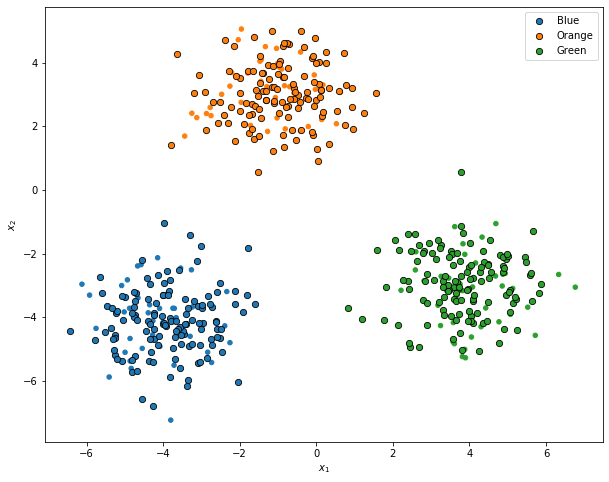

In [3]:
X_train, X_test, y_train, y_test = lin_separable_2d_3cls(500)
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## 逻辑斯蒂回归

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pylib.utils.functions_for_classification import plot_decision_boundary
import numpy as np

In [5]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    """逻辑斯蒂回归
    
    参数
    ----
    alpha: L1正则化
    learning_rate: 在梯度下降中，更新权重所用的步长
    max_iter: 在梯度下降中，所用迭代的最大步数
    W0: 权重初始值，默认为None，即使用随机初始化
    random_state: 随机数生成器的种子
    
    
    属性
    ----
    W: 最终迭代后的权重
    weight_history: 记录权重值
    loss_history: 记录损失值
    """
    def __init__(self, learning_rate=0.5, max_iter=3000, 
                 W0=None, random_state=None):
#         self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.W0 = W0
        self.seed = random_state
    
    # S型函数
    def __sigmoid_function(self, X, W, k):
        K = self.n_classes
        s = 0
        for i in range(K - 1):
            s += np.exp(X @ W[i*K: i*K+K])
        if k < K-1:
            pk = np.exp(X @ W[k*K : k*K + K]) / (s+1)
        else:
            pk = 1 / (s + 1)
        return pk
    
    def __cross_entropy(self, X, W, y):
        s = 0
        epsilon = 1e-8
        for i in range(self.n_classes):
            yi_pred = self.__sigmoid_function(X, W, i)
            s += yi_pred.T @ np.log((1 - yi_pred + epsilon))
        loss = 1 / len(y) * np.sum(s)
        return loss
    
    def __newton_cg(self, X, W, y):
        n_classes = self.n_classes
        n, p = X.shape
        P = p * (n_classes - 1)
        tol = 1e-5
        weight_history = [W.copy()]
        loss = self.__cross_entropy(X, W, y)
        loss_history = [loss]
        for e in range(1, self.max_iter+1):
            y_pred = np.zeros((n, n_classes - 1))
            grad = []
            for i in range(n_classes - 1):
                y_pred[:, i] = self.__sigmoid_function(X, W, i).ravel()
                yi = np.array(y == i).astype("int")
                gradi = yi @ X - X.T @ y_pred[:, i]
                grad.append(gradi)
            G = np.hstack(grad)  #  形成梯度向量
            H = np.zeros(((n_classes - 1)*p, (n_classes - 1)*p)) #  Hessian矩阵
            Hsi = []
            for i in range(n_classes - 1):
                Hsj = []
                for j in range(n_classes - 1):
                    if j == i:
                        h = y_pred[:, i].T @ (1 - y_pred[:, i]) * (X.T @ X)
                    else:
                        h = y_pred[:, i].T @ y_pred[:, j] * (X.T @ X)
                    Hsj.append(h)
                Hsi.append(Hsj)
            H = np.block(Hsi)  #  形成Hessian矩阵
            d = np.linalg.lstsq(H, G)[0].reshape(-1, 1)
            W += self.learning_rate * d  #  更新权重
            weight_history.append(W.copy())
            weight_change = np.sum(np.abs(np.abs(weight_history[-1]) - \
                                      np.abs(weight_history[-2])))
            if weight_change < tol or np.linalg.norm(G) < tol:
                break
            loss = self.__cross_entropy(X, W, y)
            loss_history.append(loss)
        if weight_change > tol and loss_history[-1] > tol:
            print("Logistic regression dosen't converge!")
            
        return weight_history, loss_history
    
    def fit(self, X, y=None):
        np.random.seed(self.seed)
        X = np.c_[np.ones(len(X)), X]
        p = X.shape[1]
        self.n_classes = len(np.unique(y))
        if self.W0 != None:
            W = self.W0
        else:
            # 随机初始化权重
            W = np.random.randn(p * (self.n_classes - 1), 1)
        self.weight_history, self.loss_history = self.__newton_cg(X, W, y)
        self.W = self.weight_history[-1]
        
        return self
    
    def predict_proba(self, X):
        X = np.c_[np.ones(len(X)), X]
        n = len(X)
        y_proba = np.zeros((n, self.n_classes))
        for i in range(self.n_classes):
            y_proba[:, i] = self.__sigmoid_function(X, self.W, i).ravel()
        return y_proba
    
    def predict(self, X):
        y_proba = self.predict_proba(X)
        y_pred = np.argmax(y_proba, axis=1)
        return y_pred

In [6]:
multi_logreg = LogisticRegression(learning_rate=8.0, max_iter=6000, 
                                  random_state=42)
multi_logreg.fit(X_train, y_train)

E:\a-soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


LogisticRegression(W0=None, learning_rate=8.0, max_iter=6000, random_state=None)

In [7]:
train_err = 1 - multi_logreg.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.000


In [8]:
test_err = 1 - multi_logreg.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.000


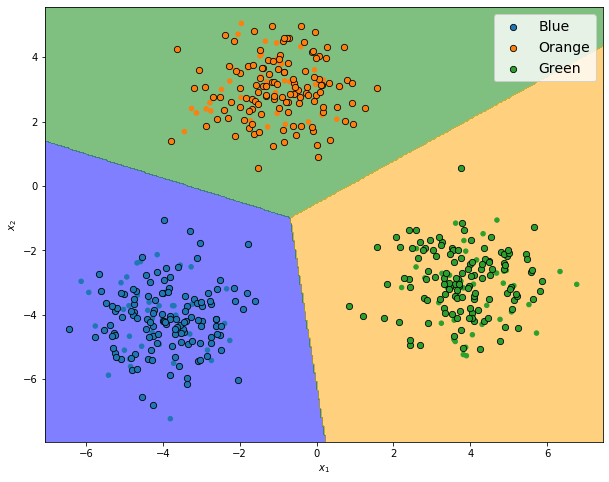

In [9]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, 
                       classifier=multi_logreg)
plt.show()

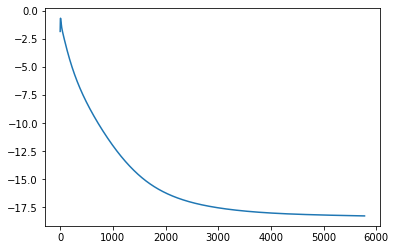

In [11]:
# 绘制历史损失值曲线
loss_history = multi_logreg.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()